# **(Modeling And Evaluation)**

## Objectives

* Build and train a custom convolutional neural network (CNN) from scratch for tumor detection in CT scans.
* Tune hyperparameters to optimize model performance.
* Evaluate the model using accuracy, recall, and inference time metrics.
* Generate model predictions and confidence scores for downstream visualization.
* Prepare the model and outputs for integration with the Streamlit dashboard.

## Inputs

* Preprocessed and augmented image data and metadata from the DataCollection notebook.
* Train/validation/test splits.
* Any configuration files or parameters for model training.

## Outputs

* Trained custom CNN model (saved in a suitable format, e.g., .h5 or .pb).
* Evaluation metrics (accuracy, recall, inference time) and confusion matrix.
* Model predictions and confidence scores for each sample.
* Artifacts for dashboard integration (e.g., prediction results, model files).

## Additional Comments

* The model should be compact enough for real-time inference (<1.5 sec/sample).
* Early stopping and validation loss monitoring should be used to prevent overfitting.
* All outputs will be used in the DataVisualization notebook and Streamlit dashboard.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/brain-tumor-classification/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir('/workspaces/brain-tumor-classification')
print("Current working directory:", os.getcwd())

Current working directory: /workspaces/brain-tumor-classification


Confirm the new current directory

**Environment Setup, Data loading and preparation**

Core libraries

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import warnings

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

2025-06-25 14:55:51.218680: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 14:55:51.239283: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 14:55:51.511640: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 14:55:51.700433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750863351.960050   41723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750863352.03

TensorFlow version: 2.19.0
Keras version: 3.10.0
Numpy version: 1.26.1
Pandas version: 2.1.1


Data Loading & Splitting

In [4]:
train_dir = "inputs/brain_tumor_dataset/images/train"
val_dir = "inputs/brain_tumor_dataset/images/val"
test_dir = "inputs/brain_tumor_dataset/images/test"

In [5]:
import os
print(os.path.exists(train_dir))
print(os.path.exists(val_dir))
print(os.path.exists(test_dir))

True
True
True


In [6]:
def count_images(directory):
	total = 0
	for label in os.listdir(directory):
		class_path = os.path.join(directory, label)
		if os.path.isdir(class_path):
			total += len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
	return total

---

Data Preparation & Normalization

Define Utility Function for tf.data Pipeline

In [7]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 8



Build File Path and Label Lists

In [8]:
import glob

def get_file_paths_and_labels(data_dir):
    class_names = sorted(os.listdir(data_dir))
    file_paths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            files = glob.glob(os.path.join(class_dir, '*'))
            file_paths.extend(files)
            labels.extend([idx] * len(files))
    return file_paths, labels, class_names

train_files, train_labels, class_names = get_file_paths_and_labels(train_dir)
val_files, val_labels, _ = get_file_paths_and_labels(val_dir)
test_files, test_labels, _ = get_file_paths_and_labels(test_dir)

neg, pos = np.bincount(train_labels)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)  
weight_for_1 = (1 / pos) * (total / 2.0) 

class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weights)

print("Classes:", class_names)
print("Train samples:", len(train_files))
print("Validation samples:", len(val_files))
print("Test samples:", len(test_files))

Class weights: {0: 1.0, 1: 1.0}
Classes: ['notumor', 'tumor']
Train samples: 7030
Validation samples: 1054
Test samples: 1054


because all images are PNG , this is a result of a debug. (34)

In [9]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

Create tf.data Datasets

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2025-06-25 14:57:28.460907: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Confirm Class Balance in Training Set

In [11]:
import numpy as np

unique, counts = np.unique(train_labels, return_counts=True)
class_balance = dict(zip(class_names, counts))
print("Class balance in training set:", class_balance)

Class balance in training set: {'notumor': 3515, 'tumor': 3515}


---

Model Architecture Design

In [37]:
from tensorflow.keras import layers, models

def build_custom_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Normalization(),  # Input normalization layer

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = build_custom_cnn()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,464 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 455 (1.78 KB)

Model Compilation.

Choose an appropriate optimizer (e.g., Adam), loss function (e.g., binary crossentropy), and evaluation metrics (accuracy, recall).
Compile the model with these settings.

Compile the Model

In [38]:
from tensorflow.keras import optimizers, metrics

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Recall()]
)

Run this to check if tensorflow could not be resolved error means tensorflow is not installed in your instance, in this case it is installed and we have no problem .

In [39]:
import sys
print(sys.executable)

/home/cistudent/.pyenv/versions/3.12.1/bin/python


# Recall-Focused Model Training.

Train the model on the training set, validating on the validation set.
Use callbacks such as EarlyStopping and ModelCheckpoint, monitoring validation recall.
Log training and validation metrics for each epoch.
Track the precision-recall tradeoff.


Set Up Callbacks

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_recall', mode='max', save_best_only=True, verbose=1)
]

In [41]:
with open(".gitignore", "a") as f:
    f.write("\n# Ignore model files\n*.h5\n*.keras\nbest_model.h5\nmy_model.keras\n")

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)

In [ ]:
model.save("my_model.keras")
print("Model saved locally as my_model.keras")

here you can load the model  below

In [42]:
from tensorflow import keras
model = keras.models.load_model("my_model.keras")

Evaluate the Model on the Test Set

In [43]:
test_loss, test_acc, test_recall = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.5511 - loss: 1.7694 - recall: 0.7186
Test Loss: 0.7625
Test Accuracy: 0.8017
Test Recall: 0.9973


Generate Predictions and Confidence Scores

In [44]:
import numpy as np

y_true = np.array(test_labels)
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step


Compute and Visualize the Confusion Matrix

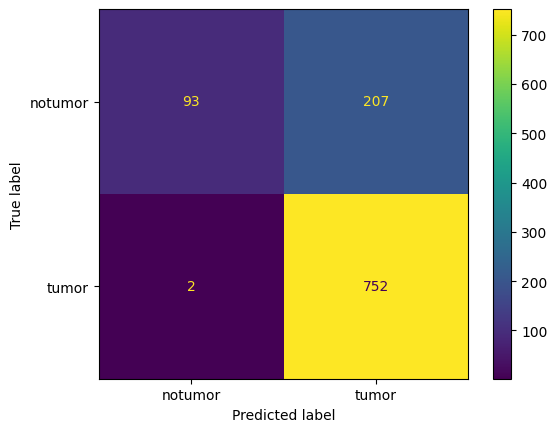

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

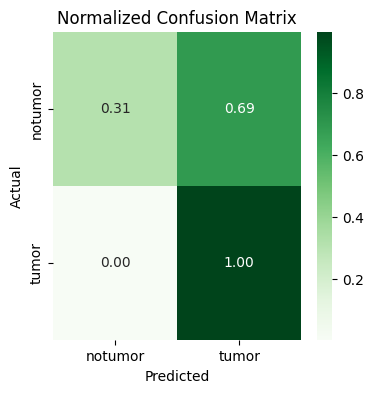

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(4,4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

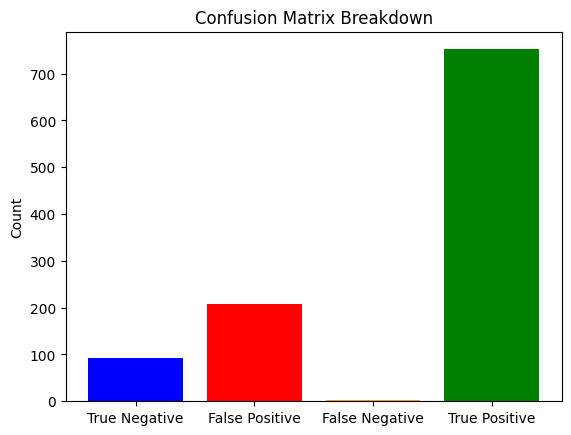

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
values = [cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
plt.bar(labels, values, color=['blue', 'red', 'orange', 'green'])
plt.ylabel('Count')
plt.title('Confusion Matrix Breakdown')
plt.show()

 Save Evaluation Metrics and Predictions


In [46]:
import pandas as pd

results_df = pd.DataFrame({
    "true_label": y_true,
    "predicted_label": y_pred,
    "confidence": y_pred_probs
})
results_df.to_csv("test_predictions.csv", index=False)

In [47]:
# y_true: true labels (0 = no tumor, 1 = tumor)
# y_pred: predicted labels (0 = no tumor, 1 = tumor)

# False positives: model predicts tumor (1) but true label is no tumor (0)
false_positives = np.sum((y_true == 0) & (y_pred == 1))
total_negatives = np.sum(y_true == 0)
false_positive_rate = false_positives / total_negatives

print(f"False positive rate: {false_positive_rate:.4f}")

# Expected false positives in 10 no-tumor images:
expected_fp = false_positive_rate * 10
print(f"Expected false tumors in 10 no-tumor images: {expected_fp:.2f}")

False positive rate: 0.6900
Expected false tumors in 10 no-tumor images: 6.90
